In [2]:
# 필요한 패키지 로드
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import VAR
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch, normal_ad
import warnings
warnings.filterwarnings("ignore")

# 엑셀 파일 불러오기
df = pd.read_excel("df_diff1.xlsx", index_col=0)

# 필요한 변수만 추출
df_var = df[['매출액', '연구개발비', '소비자물가총지수']].dropna()

# 시계열 인덱스로 변환 (연도 데이터일 경우)
df_var.index = pd.PeriodIndex(df_var.index, freq='Q')  # 또는 freq='Y' if annual


In [3]:
# VAR 모델 적합
model = VAR(df_var)
results = model.fit(maxlags=2, ic='aic')  # maxlags는 사용자가 조절 가능
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 07, Jul, 2025
Time:                     08:35:46
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -18.9780
Nobs:                     57.0000    HQIC:                  -19.4382
Log likelihood:           340.687    FPE:                2.70823e-09
AIC:                     -19.7307    Det(Omega_mle):     1.91325e-09
--------------------------------------------------------------------
Results for equation 매출액
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              -0.014081         0.018329           -0.768           0.442
L1.매출액             -0.778367         0.123327           -6.311           0.000
L1.연구개발비            0.115931         0.062950            1.842        

In [4]:
##모델 잔차 검정
# 잔차 불러오기
resid = results.resid

# 1. Ljung-Box 자기상관 검정
print("✅ Ljung-Box Test (자기상관 검정)")
for col in resid.columns:
    lb_test = acorr_ljungbox(resid[col], lags=[10], return_df=True)
    print(f"{col}:\n{lb_test}\n")


✅ Ljung-Box Test (자기상관 검정)
매출액:
     lb_stat  lb_pvalue
10  16.86874   0.077319

연구개발비:
      lb_stat  lb_pvalue
10  14.126979   0.167278

소비자물가총지수:
     lb_stat  lb_pvalue
10  25.04098   0.005268



In [5]:
# 2. Jarque-Bera 정규성 검정
print("✅ Jarque-Bera Test (정규성 검정)")
for col in resid.columns:
    jb_stat, jb_p = normal_ad(resid[col])
    print(f"{col}: JB-stat={jb_stat:.3f}, p-value={jb_p:.4f}")


✅ Jarque-Bera Test (정규성 검정)
매출액: JB-stat=0.179, p-value=0.9140
연구개발비: JB-stat=0.487, p-value=0.2160
소비자물가총지수: JB-stat=1.247, p-value=0.0028


In [6]:
# 3. ARCH Test (이분산성 검정)
print("✅ ARCH Test (이분산성 검정)")
for col in resid.columns:
    arch_test = het_arch(resid[col])
    print(f"{col}: ARCH LM p-value={arch_test[1]:.4f}")

✅ ARCH Test (이분산성 검정)
매출액: ARCH LM p-value=0.2818
연구개발비: ARCH LM p-value=0.5440
소비자물가총지수: ARCH LM p-value=0.3789


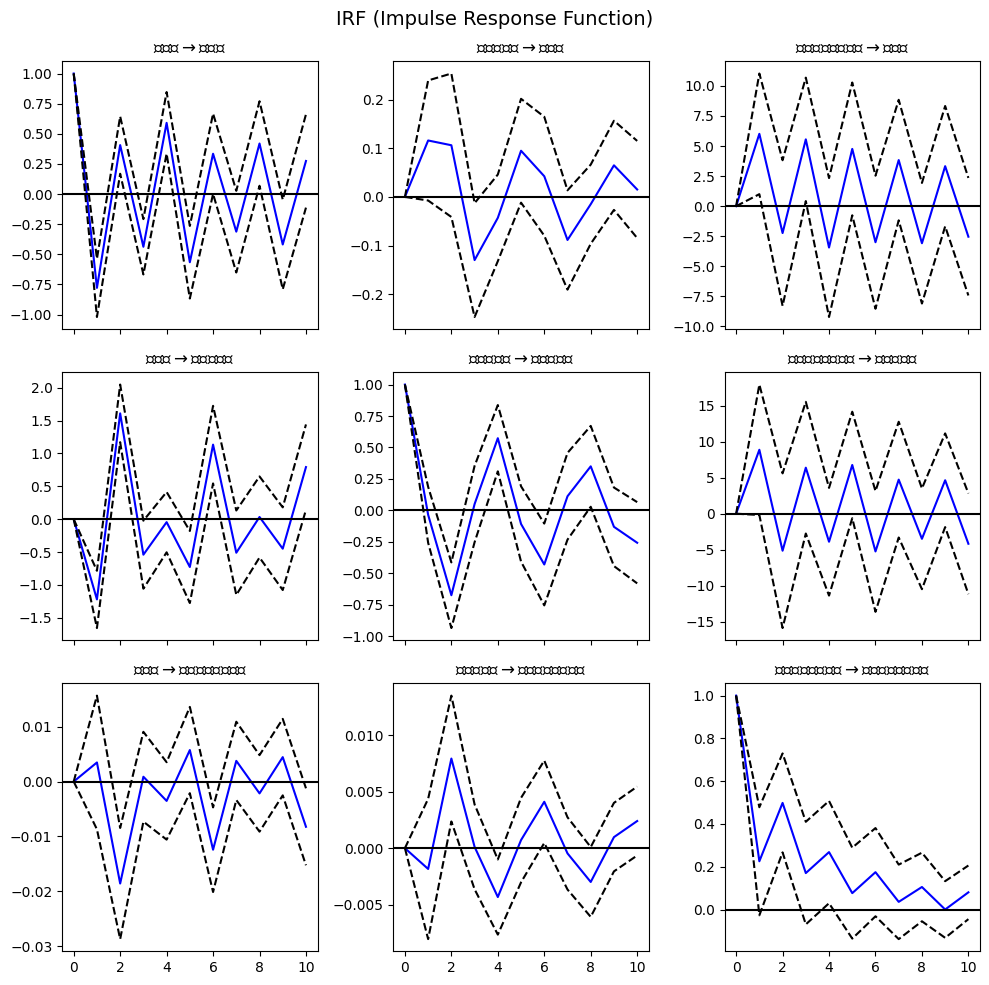

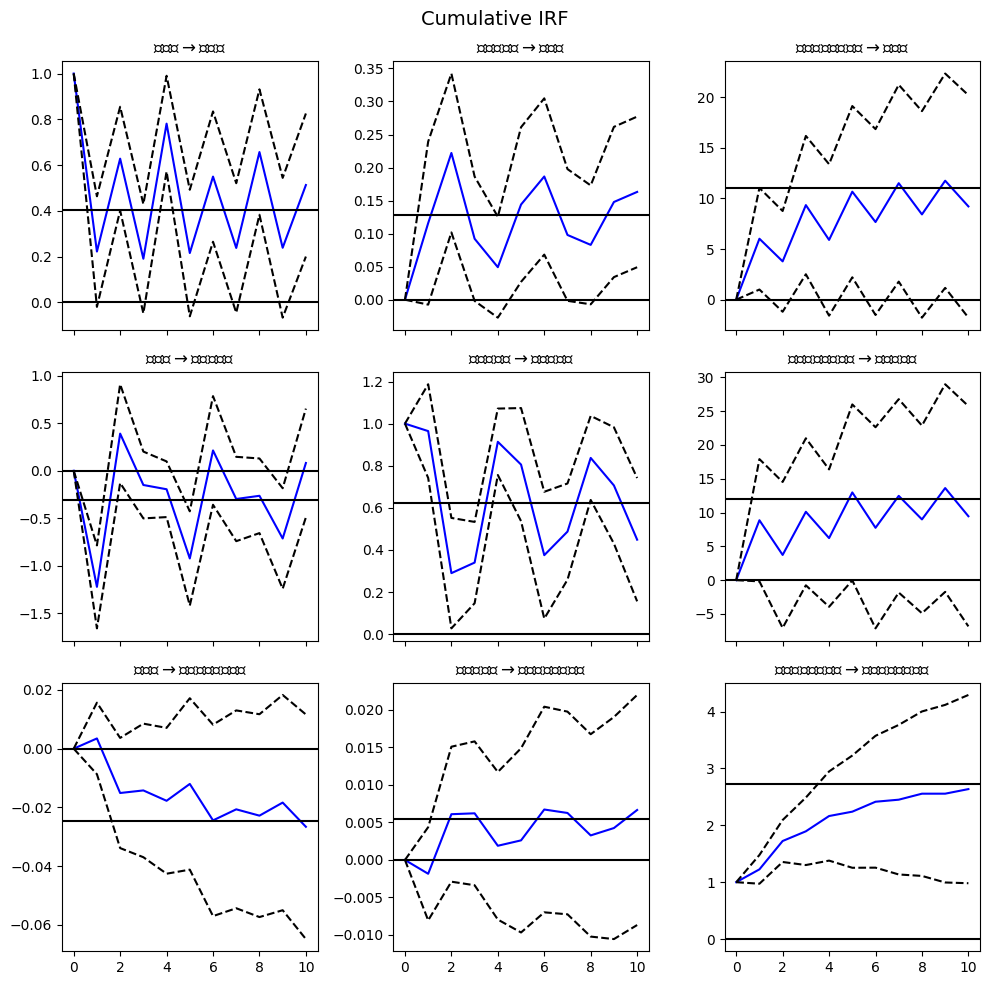

In [7]:
# IRF 객체 생성
irf = results.irf(10)  # 시차 10까지

# 1. 전체 IRF
irf.plot(orth=False)
plt.suptitle("IRF (Impulse Response Function)", fontsize=14)
plt.tight_layout()
plt.show()

# 2. 누적 IRF
irf.plot_cum_effects(orth=False)
plt.suptitle("Cumulative IRF", fontsize=14)
plt.tight_layout()
plt.show()


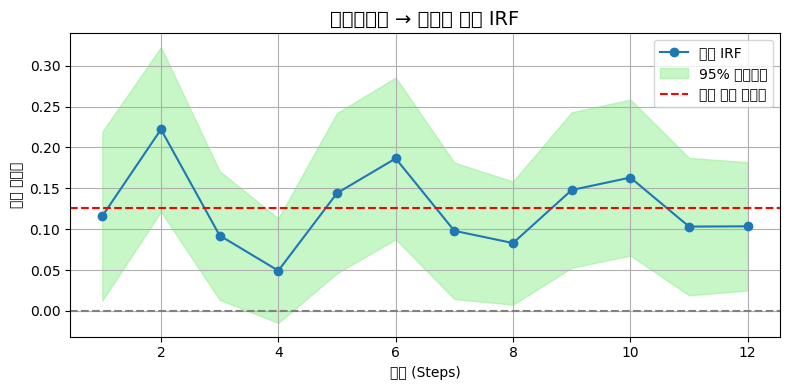

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.api import VAR

model = VAR(df_var)              # ✅ df_var는 VAR 분석에 사용할 데이터프레임
var_res = model.fit(maxlags=2)   # ✅ AIC/BIC 기준 적절한 시차 선택


# ✅ 1. 충격반응분석 객체 생성 (시차 horizon 지정)
horizon = 12  # 분석 시차: 8분기까지
irf = var_res.irf(horizon)

# ✅ 2. 변수명 설정 (충격변수 → 반응변수)
impulse_var  = '연구개발비'
response_var = '매출액'

# ✅ 누적 IRF 및 신뢰구간 (시차 1~horizon까지만 사용)
cum_irf_vals = irf.cum_effects[1:horizon+1, resp_idx, imp_idx]
stderr_vals = irf.cum_effect_stderr(orth=False)[1:horizon+1, resp_idx, imp_idx]
ci_upper = cum_irf_vals + 1.96 * stderr_vals
ci_lower = cum_irf_vals - 1.96 * stderr_vals
mean_val = np.mean(cum_irf_vals)

# ✅ 시각화 (x축도 range(1, horizon+1)로 조정)
plt.figure(figsize=(8, 4))
plt.plot(range(1, horizon+1), cum_irf_vals, marker='o', label='누적 IRF')
plt.fill_between(range(1, horizon+1), ci_lower, ci_upper, color='lightgreen', alpha=0.5, label='95% 신뢰구간')
plt.axhline(0, color='gray', linestyle='--')
plt.axhline(mean_val, color='red', linestyle='--', label='평균 누적 반응값')
plt.title(f'{impulse_var} → {response_var} 누적 IRF', fontsize=14)
plt.xlabel('시차 (Steps)')
plt.ylabel('누적 반응값')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


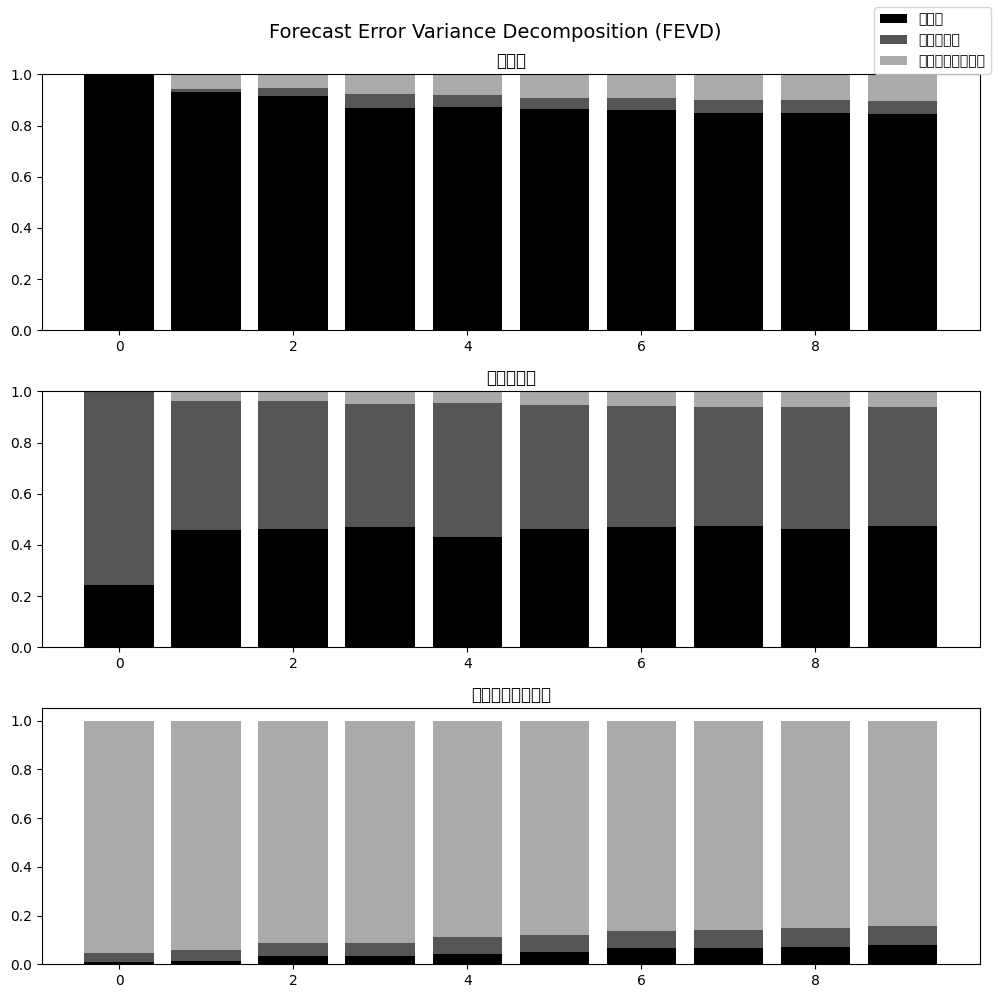

In [10]:
# FEVD 객체 생성 (시차 10까지)
fevd = results.fevd(10)

# 1. 시각화
fevd.plot()
plt.suptitle("Forecast Error Variance Decomposition (FEVD)", fontsize=14)
plt.tight_layout()
plt.show()